In [22]:
import copy
import random
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda")

HP = {
    "meta_iterations": 2000,
    "meta_batch_size": 32,
    "inner_steps": 1,
    "inner_lr": 0.01,
    "meta_lr": 1e-3,

    "support_k": 10,
    "query_q": 100,
    "test_query_q": 100,

    "eval_tasks": 600,
    "max_finetune_steps": 10,

    "hidden": 40,
    "radius": 2.0
}

loss_fn = nn.BCEWithLogitsLoss()

In [5]:
def sample_task(K, Q, radius):
    cx, cy = np.random.uniform(-3, 3, size=2)

    def label_fn(x):
        d = (x[:, 0] - cx)**2 + (x[:, 1] - cy)**2
        return (d < radius**2).astype(np.float32)

    xs = np.random.uniform(-5, 5, size=(K, 2)).astype(np.float32)
    ys = label_fn(xs).reshape(-1, 1)

    xq = np.random.uniform(-5, 5, size=(Q, 2)).astype(np.float32)
    yq = label_fn(xq).reshape(-1, 1)

    return (
        torch.tensor(xs).to(device),
        torch.tensor(ys).to(device),
        torch.tensor(xq).to(device),
        torch.tensor(yq).to(device),
        (cx, cy)
    )

In [6]:
class MLP(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [19]:
def functional_forward(model, params, x):
    w1, b1, w2, b2, w3, b3 = params

    x = F.linear(x, w1, b1)
    x = F.relu(x)
    x = F.linear(x, w2, b2)
    x = F.relu(x)
    x = F.linear(x, w3, b3)

    return x


In [31]:
def accuracy(logits, y):
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds == y).float().mean().item()

def finetune_and_eval(model, xs, ys, xq, yq, steps):
    temp = copy.deepcopy(model)
    opt = torch.optim.SGD(temp.parameters(), lr=HP["inner_lr"])

    for _ in range(steps):
        opt.zero_grad()
        loss = loss_fn(temp(xs), ys)
        loss.backward()
        opt.step()

    with torch.no_grad():
        return accuracy(temp(xq), yq)

In [32]:
def train_maml():

    model = MLP(HP["hidden"]).to(device)
    meta_opt = torch.optim.Adam(model.parameters(), lr=HP["meta_lr"])
    loss_fn = nn.BCEWithLogitsLoss()

    for _ in tqdm(range(HP["meta_iterations"]), desc="MAML training"):

        meta_loss = 0

        for _ in range(HP["meta_batch_size"]):

            xs, ys, xq, yq, _ = sample_task(
                HP["support_k"], HP["query_q"], HP["radius"]
            )

            params = [p for p in model.parameters()]

            logits = functional_forward(model, params, xs)
            loss = loss_fn(logits, ys)

            grads = torch.autograd.grad(loss, params, create_graph=True)

            adapted_params = [
                p - HP["inner_lr"] * g
                for p, g in zip(params, grads)
            ]

            q_logits = functional_forward(model, adapted_params, xq)
            q_loss = loss_fn(q_logits, yq)

            meta_loss += q_loss

        meta_loss /= HP["meta_batch_size"]

        meta_opt.zero_grad()
        meta_loss.backward()
        meta_opt.step()

    return model


In [33]:
def train_baseline():
    model = MLP(HP["hidden"]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=HP["meta_lr"])

    for _ in tqdm(range(HP["meta_iterations"]), desc="Baseline training"):

        xs_list = []
        ys_list = []

        for _ in range(HP["meta_batch_size"]):
            xs, ys, _, _, _ = sample_task(
                HP["support_k"], HP["query_q"], HP["radius"]
            )
            xs_list.append(xs)
            ys_list.append(ys)

        batch_x = torch.cat(xs_list, dim=0)
        batch_y = torch.cat(ys_list, dim=0)

        opt.zero_grad()
        loss = loss_fn(model(batch_x), batch_y)
        loss.backward()
        opt.step()

    return model

In [36]:
def evaluate_models(maml, baseline):

    max_steps = HP["max_finetune_steps"]

    maml_acc = np.zeros(max_steps + 1)
    base_acc = np.zeros(max_steps + 1)

    for _ in tqdm(range(HP["eval_tasks"]), desc="Evaluation"):
        # one test task
        xs, ys, xq, yq, _ = sample_task(
            HP["support_k"], HP["test_query_q"], HP["radius"]
        )
        # copy models ONCE per task
        maml_temp = copy.deepcopy(maml)
        base_temp = copy.deepcopy(baseline)
        maml_opt = torch.optim.SGD(maml_temp.parameters(), lr=HP["inner_lr"])
        base_opt = torch.optim.SGD(base_temp.parameters(), lr=HP["inner_lr"])

        # step 0 (before adaptation)
        with torch.no_grad():
            maml_acc[0] += accuracy(maml_temp(xq), yq)
            base_acc[0] += accuracy(base_temp(xq), yq)

        # incremental adaptation
        for step in range(1, max_steps + 1):

            maml_opt.zero_grad()
            loss_m = loss_fn(maml_temp(xs), ys)
            loss_m.backward()
            maml_opt.step()

            base_opt.zero_grad()
            loss_b = loss_fn(base_temp(xs), ys)
            loss_b.backward()
            base_opt.step()

            with torch.no_grad():
                maml_acc[step] += accuracy(maml_temp(xq), yq)
                base_acc[step] += accuracy(base_temp(xq), yq)

    maml_acc /= HP["eval_tasks"]
    base_acc /= HP["eval_tasks"]

    return maml_acc, base_acc


In [37]:
def visualize_task(model, title):
    xs, ys, _, _, center = sample_task(
        HP["support_k"], HP["test_query_q"], HP["radius"]
    )

    temp = copy.deepcopy(model)
    opt = torch.optim.SGD(temp.parameters(), lr=HP["inner_lr"])

    opt.zero_grad()
    loss = loss_fn(temp(xs), ys)
    loss.backward()
    opt.step()

    grid = np.linspace(-5, 5, 200)
    gx, gy = np.meshgrid(grid, grid)
    pts = np.stack([gx.ravel(), gy.ravel()], axis=1).astype(np.float32)
    pts = torch.tensor(pts).to(device)

    with torch.no_grad():
        probs = torch.sigmoid(temp(pts)).cpu().numpy()
    probs = probs.reshape(200, 200)

    plt.figure(figsize=(5,5))
    plt.imshow(probs, origin="lower", extent=[-5,5,-5,5])
    plt.scatter(xs[:,0].cpu(), xs[:,1].cpu(), c=ys.cpu(), edgecolors='k')
    circle = plt.Circle(center, HP["radius"], fill=False)
    plt.gca().add_patch(circle)
    plt.title(title)
    plt.colorbar()
    plt.show()

Evaluation: 100%|██████████| 600/600 [00:20<00:00, 28.65it/s]


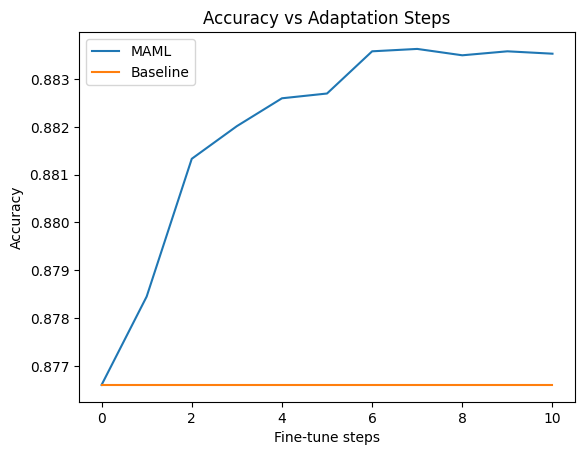

In [41]:
maml_model = train_maml()
baseline_model = train_baseline()

maml_acc, base_acc = evaluate_models(maml_model, baseline_model)

steps = np.arange(len(maml_acc))

plt.figure()
plt.plot(steps, maml_acc, label="MAML")
plt.plot(steps, base_acc, label="Baseline")
plt.xlabel("Fine-tune steps")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Adaptation Steps")
plt.show()


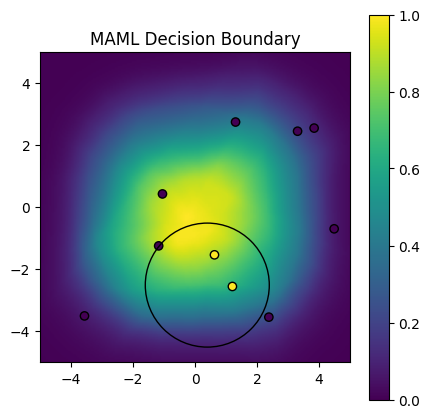

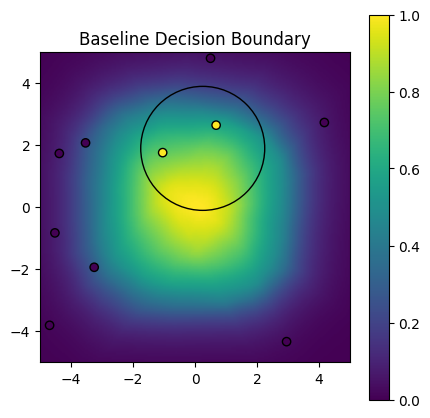

In [42]:
visualize_task(maml_model, "MAML Decision Boundary")
visualize_task(baseline_model, "Baseline Decision Boundary")